In [67]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [69]:
import tonic
import torchvision

sensor_size = tonic.datasets.NMNIST.sensor_size
frame_transform = tonic.transforms.ToFrame(sensor_size=sensor_size, time_window=1000)

trainset = tonic.datasets.NMNIST(save_to="./data", train=True)
testset = tonic.datasets.NMNIST(
    save_to="./data", transform=frame_transform, train=False
)

In [70]:
events = trainset[0][0]
events

array([(10, 30,    937, 1), (33, 20,   1030, 1), (12, 27,   1052, 1), ...,
       ( 7, 15, 302706, 1), (26, 11, 303852, 1), (11, 17, 305341, 1)],
      dtype=[('x', '<i8'), ('y', '<i8'), ('t', '<i8'), ('p', '<i8')])

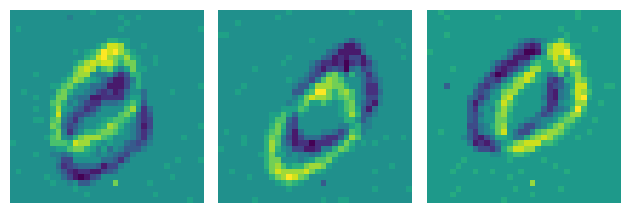

In [73]:
tonic.utils.plot_event_grid(events)

In [75]:
trainset[0][1]

0

In [11]:
# reduce this number if you run out of GPU memory
BATCH_SIZE = 32

# add sparse transform to trainset, previously omitted because we wanted to look at raw events
trainset.transform = frame_transform

train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=BATCH_SIZE,
    collate_fn=tonic.collation.PadTensors(batch_first=False),
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    testset,
    batch_size=BATCH_SIZE,
    collate_fn=tonic.collation.PadTensors(batch_first=False),
    shuffle=False,
)

In [13]:
from norse.torch import LIFParameters, LIFState
from norse.torch.module.lif import LIFCell, LIFRecurrentCell

# Notice the difference between "LIF" (leaky integrate-and-fire) and "LI" (leaky integrator)
from norse.torch import LICell, LIState

from typing import NamedTuple


class SNNState(NamedTuple):
    lif0: LIFState
    readout: LIState


class SNN(torch.nn.Module):
    def __init__(
        self,
        input_features,
        hidden_features,
        output_features,
        tau_syn_inv,
        tau_mem_inv,
        record=False,
        dt=1e-3,
    ):
        super(SNN, self).__init__()
        self.l1 = LIFRecurrentCell(
            input_features,
            hidden_features,
            p=LIFParameters(
                alpha=100,
                v_th=torch.as_tensor(0.3),
                tau_syn_inv=tau_syn_inv,
                tau_mem_inv=tau_mem_inv,
            ),
            dt=dt,
        )
        self.input_features = input_features
        self.fc_out = torch.nn.Linear(hidden_features, output_features, bias=False)
        self.out = LICell(dt=dt)

        self.hidden_features = hidden_features
        self.output_features = output_features
        self.record = record

    def forward(self, x):
        seq_length, batch_size, _, _, _ = x.shape
        s1 = so = None
        voltages = []

        if self.record:
            self.recording = SNNState(
                LIFState(
                    z=torch.zeros(seq_length, batch_size, self.hidden_features),
                    v=torch.zeros(seq_length, batch_size, self.hidden_features),
                    i=torch.zeros(seq_length, batch_size, self.hidden_features),
                ),
                LIState(
                    v=torch.zeros(seq_length, batch_size, self.output_features),
                    i=torch.zeros(seq_length, batch_size, self.output_features),
                ),
            )

        for ts in range(seq_length):
            z = x[ts, :, :, :].view(-1, self.input_features)
            z, s1 = self.l1(z, s1)
            z = self.fc_out(z)
            vo, so = self.out(z, so)
            if self.record:
                self.recording.lif0.z[ts, :] = s1.z
                self.recording.lif0.v[ts, :] = s1.v
                self.recording.lif0.i[ts, :] = s1.i
                self.recording.readout.v[ts, :] = so.v
                self.recording.readout.i[ts, :] = so.i
            voltages += [vo]

        return torch.stack(voltages)

/Users/sophie/miniconda3/envs/neuromorphic_env/lib/python3.9/site-packages/torch/utils/_cxx_pytree.py:238: UserWarning: PyTree type <class 'norse.torch.utils.pytree.LIFParameters'> is a subclass of `collections.namedtuple`, which is already registered in the global namespace. Override it with custom flatten/unflatten functions in namespace 'torch'.
  optree.register_pytree_node(
/Users/sophie/miniconda3/envs/neuromorphic_env/lib/python3.9/site-packages/torch/utils/_cxx_pytree.py:238: UserWarning: PyTree type <class 'norse.torch.utils.pytree.LIFState'> is a subclass of `collections.namedtuple`, which is already registered in the global namespace. Override it with custom flatten/unflatten functions in namespace 'torch'.
  optree.register_pytree_node(
/Users/sophie/miniconda3/envs/neuromorphic_env/lib/python3.9/site-packages/torch/utils/_cxx_pytree.py:238: UserWarning: PyTree type <class 'norse.torch.utils.pytree.LIFFeedForwardState'> is a subclass of `collections.namedtuple`, which is al

In [14]:
example_snn = SNN(
    np.product(trainset.sensor_size),
    100,
    len(trainset.classes),
    tau_syn_inv=torch.tensor(1 / 1e-2),
    tau_mem_inv=torch.tensor(1 / 1e-2),
    record=True,
    dt=1e-3,
)

frames, target = next(iter(train_loader))

frames[:, :1].shape

torch.Size([311, 1, 2, 34, 34])

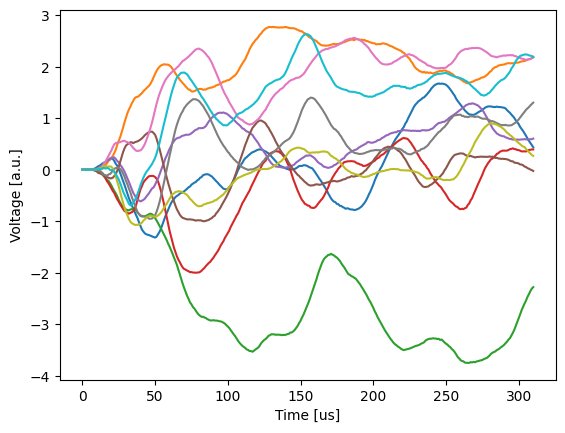

In [45]:
example_readout_voltages = example_snn(frames[:, :1])
voltages = example_readout_voltages.squeeze(1).detach().numpy()

plt.plot(voltages)
plt.ylabel("Voltage [a.u.]")
plt.xlabel("Time [us]")
plt.show()

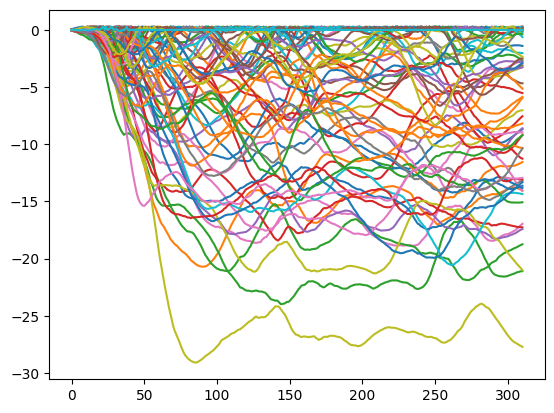

In [19]:
plt.plot(example_snn.recording.lif0.v.squeeze(1).detach().numpy())
plt.show()

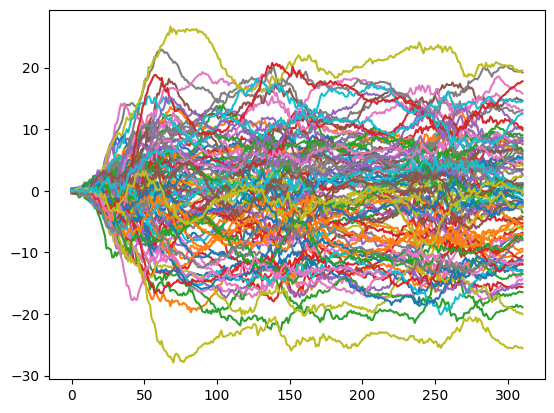

In [21]:
plt.plot(example_snn.recording.lif0.i.squeeze(1).detach().numpy())
plt.show()

Final accuracy: 95.78%

Anmerkung: Ausführungszeit = 4 Stunden

In [25]:
import torch
from tqdm.notebook import tqdm
import numpy as np
import tonic


In [27]:
# Hyperparameter
BATCH_SIZE = 64
LR = 0.002
HIDDEN_FEATURES = 100
EPOCHS = 10

# Setze Sparse-Transformation für den Trainingsdatensatz
trainset.transform = frame_transform

# DataLoader erstellen
def create_data_loader(dataset, batch_size, shuffle=False):
    return torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        collate_fn=tonic.collation.PadTensors(batch_first=False),
        shuffle=shuffle,
    )

train_loader = create_data_loader(trainset, BATCH_SIZE, shuffle=True)
test_loader = create_data_loader(testset, BATCH_SIZE)


In [29]:
# Decoder-Funktion
def decode(x):
    return torch.nn.functional.log_softmax(torch.max(x, 0)[0], dim=1)


In [31]:
# Modellklasse
class Model(torch.nn.Module):
    def __init__(self, snn):
        super(Model, self).__init__()
        self.snn = snn

    def forward(self, x):
        return decode(self.snn(x))


In [33]:
# Gerät auswählen
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Modell initialisieren
INPUT_FEATURES = np.product(trainset.sensor_size)
OUTPUT_FEATURES = len(trainset.classes)

model = Model(
    snn=SNN(
        input_features=INPUT_FEATURES,
        hidden_features=HIDDEN_FEATURES,
        output_features=OUTPUT_FEATURES,
        tau_syn_inv=torch.tensor(1 / 1e-2),
        tau_mem_inv=torch.tensor(1 / 1e-2),
    )
).to(DEVICE)


In [35]:
# Optimierer initialisieren
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


In [37]:
# Trainings- und Testfunktion
def run_epoch(model, device, data_loader, optimizer=None):
    if optimizer:
        model.train()
    else:
        model.eval()

    losses = []
    correct = 0

    with torch.set_grad_enabled(optimizer is not None):
        for batch_idx, (data, target) in enumerate(tqdm(data_loader)):
            data, target = data.to(device), target.to(device)
            output = model(data)

            if optimizer:
                loss = torch.nn.functional.nll_loss(output, target)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                losses.append(loss.item())

                if (batch_idx + 1) % 10 == 0:  # Ausgabe alle 10 Batches
                    print(f"Epoch {epoch + 1}, Batch {batch_idx + 1}/{len(data_loader)}, Loss: {loss.item():.4f}")
            else:
                loss = torch.nn.functional.nll_loss(output, target, reduction='sum')
                losses.append(loss.item())
                pred = output.argmax(dim=1)
                correct += pred.eq(target.view_as(pred)).sum().item()

    if optimizer:
        mean_loss = np.mean(losses)
        print(f"Epoch completed. Mean Loss: {mean_loss:.4f}")
        return losses, mean_loss
    else:
        test_loss = sum(losses) / len(data_loader.dataset)
        accuracy = 100. * correct / len(data_loader.dataset)
        return test_loss, accuracy


In [39]:
# Training über mehrere Epochen
training_losses, mean_losses, test_losses, accuracies = [], [], [], []

for epoch in range(EPOCHS):
    print(f"Starting Epoch {epoch + 1}/{EPOCHS}")
    training_loss, mean_loss = run_epoch(model, DEVICE, train_loader, optimizer)
    
    test_loss, accuracy = run_epoch(model, DEVICE, test_loader)
    
    training_losses.extend(training_loss)
    mean_losses.append(mean_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)

print(f"Final accuracy: {accuracies[-1]:.2f}%")


Starting Epoch 1/10


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1, Batch 10/938, Loss: 2.2323
Epoch 1, Batch 20/938, Loss: 2.0898
Epoch 1, Batch 30/938, Loss: 1.7085
Epoch 1, Batch 40/938, Loss: 1.5785
Epoch 1, Batch 50/938, Loss: 1.3806
Epoch 1, Batch 60/938, Loss: 1.3031
Epoch 1, Batch 70/938, Loss: 1.0075
Epoch 1, Batch 80/938, Loss: 0.7335
Epoch 1, Batch 90/938, Loss: 0.7320
Epoch 1, Batch 100/938, Loss: 0.6960
Epoch 1, Batch 110/938, Loss: 0.6141
Epoch 1, Batch 120/938, Loss: 0.6393
Epoch 1, Batch 130/938, Loss: 0.7144
Epoch 1, Batch 140/938, Loss: 0.3615
Epoch 1, Batch 150/938, Loss: 0.5898
Epoch 1, Batch 160/938, Loss: 0.6402
Epoch 1, Batch 170/938, Loss: 0.4027
Epoch 1, Batch 180/938, Loss: 0.4384
Epoch 1, Batch 190/938, Loss: 0.4645
Epoch 1, Batch 200/938, Loss: 0.4155
Epoch 1, Batch 210/938, Loss: 0.4194
Epoch 1, Batch 220/938, Loss: 0.5647
Epoch 1, Batch 230/938, Loss: 0.3635
Epoch 1, Batch 240/938, Loss: 0.5083
Epoch 1, Batch 250/938, Loss: 0.5259
Epoch 1, Batch 260/938, Loss: 0.5240
Epoch 1, Batch 270/938, Loss: 0.4154
Epoch 1, B

  0%|          | 0/157 [00:00<?, ?it/s]

Starting Epoch 2/10


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2, Batch 10/938, Loss: 0.1176
Epoch 2, Batch 20/938, Loss: 0.2487
Epoch 2, Batch 30/938, Loss: 0.3837
Epoch 2, Batch 40/938, Loss: 0.3400
Epoch 2, Batch 50/938, Loss: 0.3695
Epoch 2, Batch 60/938, Loss: 0.1747
Epoch 2, Batch 70/938, Loss: 0.3307
Epoch 2, Batch 80/938, Loss: 0.1876
Epoch 2, Batch 90/938, Loss: 0.3232
Epoch 2, Batch 100/938, Loss: 0.2641
Epoch 2, Batch 110/938, Loss: 0.1454
Epoch 2, Batch 120/938, Loss: 0.1519
Epoch 2, Batch 130/938, Loss: 0.2062
Epoch 2, Batch 140/938, Loss: 0.2786
Epoch 2, Batch 150/938, Loss: 0.1184
Epoch 2, Batch 160/938, Loss: 0.1618
Epoch 2, Batch 170/938, Loss: 0.4153
Epoch 2, Batch 180/938, Loss: 0.4021
Epoch 2, Batch 190/938, Loss: 0.1762
Epoch 2, Batch 200/938, Loss: 0.0969
Epoch 2, Batch 210/938, Loss: 0.1132
Epoch 2, Batch 220/938, Loss: 0.1562
Epoch 2, Batch 230/938, Loss: 0.1453
Epoch 2, Batch 240/938, Loss: 0.1262
Epoch 2, Batch 250/938, Loss: 0.2327
Epoch 2, Batch 260/938, Loss: 0.2601
Epoch 2, Batch 270/938, Loss: 0.1838
Epoch 2, B

  0%|          | 0/157 [00:00<?, ?it/s]

Starting Epoch 3/10


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3, Batch 10/938, Loss: 0.2338
Epoch 3, Batch 20/938, Loss: 0.3145
Epoch 3, Batch 30/938, Loss: 0.1758
Epoch 3, Batch 40/938, Loss: 0.1752
Epoch 3, Batch 50/938, Loss: 0.1301
Epoch 3, Batch 60/938, Loss: 0.1007
Epoch 3, Batch 70/938, Loss: 0.2114
Epoch 3, Batch 80/938, Loss: 0.2988
Epoch 3, Batch 90/938, Loss: 0.2308
Epoch 3, Batch 100/938, Loss: 0.1940
Epoch 3, Batch 110/938, Loss: 0.3270
Epoch 3, Batch 120/938, Loss: 0.2003
Epoch 3, Batch 130/938, Loss: 0.3940
Epoch 3, Batch 140/938, Loss: 0.2980
Epoch 3, Batch 150/938, Loss: 0.2024
Epoch 3, Batch 160/938, Loss: 0.3341
Epoch 3, Batch 170/938, Loss: 0.2244
Epoch 3, Batch 180/938, Loss: 0.2091
Epoch 3, Batch 190/938, Loss: 0.1361
Epoch 3, Batch 200/938, Loss: 0.0923
Epoch 3, Batch 210/938, Loss: 0.1126
Epoch 3, Batch 220/938, Loss: 0.1017
Epoch 3, Batch 230/938, Loss: 0.1088
Epoch 3, Batch 240/938, Loss: 0.2712
Epoch 3, Batch 250/938, Loss: 0.1001
Epoch 3, Batch 260/938, Loss: 0.2833
Epoch 3, Batch 270/938, Loss: 0.1652
Epoch 3, B

  0%|          | 0/157 [00:00<?, ?it/s]

Starting Epoch 4/10


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4, Batch 10/938, Loss: 0.3603
Epoch 4, Batch 20/938, Loss: 0.1370
Epoch 4, Batch 30/938, Loss: 0.2181
Epoch 4, Batch 40/938, Loss: 0.2374
Epoch 4, Batch 50/938, Loss: 0.2107
Epoch 4, Batch 60/938, Loss: 0.2612
Epoch 4, Batch 70/938, Loss: 0.4773
Epoch 4, Batch 80/938, Loss: 0.2043
Epoch 4, Batch 90/938, Loss: 0.0743
Epoch 4, Batch 100/938, Loss: 0.0762
Epoch 4, Batch 110/938, Loss: 0.2875
Epoch 4, Batch 120/938, Loss: 0.2751
Epoch 4, Batch 130/938, Loss: 0.1129
Epoch 4, Batch 140/938, Loss: 0.1520
Epoch 4, Batch 150/938, Loss: 0.1602
Epoch 4, Batch 160/938, Loss: 0.3393
Epoch 4, Batch 170/938, Loss: 0.0893
Epoch 4, Batch 180/938, Loss: 0.1593
Epoch 4, Batch 190/938, Loss: 0.1054
Epoch 4, Batch 200/938, Loss: 0.1845
Epoch 4, Batch 210/938, Loss: 0.1893
Epoch 4, Batch 220/938, Loss: 0.1907
Epoch 4, Batch 230/938, Loss: 0.1816
Epoch 4, Batch 240/938, Loss: 0.1286
Epoch 4, Batch 250/938, Loss: 0.2376
Epoch 4, Batch 260/938, Loss: 0.1755
Epoch 4, Batch 270/938, Loss: 0.1535
Epoch 4, B

  0%|          | 0/157 [00:00<?, ?it/s]

Starting Epoch 5/10


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5, Batch 10/938, Loss: 0.1453
Epoch 5, Batch 20/938, Loss: 0.0448
Epoch 5, Batch 30/938, Loss: 0.1645
Epoch 5, Batch 40/938, Loss: 0.0778
Epoch 5, Batch 50/938, Loss: 0.1642
Epoch 5, Batch 60/938, Loss: 0.0908
Epoch 5, Batch 70/938, Loss: 0.1822
Epoch 5, Batch 80/938, Loss: 0.2549
Epoch 5, Batch 90/938, Loss: 0.0845
Epoch 5, Batch 100/938, Loss: 0.0826
Epoch 5, Batch 110/938, Loss: 0.2696
Epoch 5, Batch 120/938, Loss: 0.1261
Epoch 5, Batch 130/938, Loss: 0.0760
Epoch 5, Batch 140/938, Loss: 0.0554
Epoch 5, Batch 150/938, Loss: 0.2822
Epoch 5, Batch 160/938, Loss: 0.0896
Epoch 5, Batch 170/938, Loss: 0.2233
Epoch 5, Batch 180/938, Loss: 0.1021
Epoch 5, Batch 190/938, Loss: 0.1771
Epoch 5, Batch 200/938, Loss: 0.1913
Epoch 5, Batch 210/938, Loss: 0.0837
Epoch 5, Batch 220/938, Loss: 0.1160
Epoch 5, Batch 230/938, Loss: 0.1415
Epoch 5, Batch 240/938, Loss: 0.1577
Epoch 5, Batch 250/938, Loss: 0.1210
Epoch 5, Batch 260/938, Loss: 0.1042
Epoch 5, Batch 270/938, Loss: 0.0915
Epoch 5, B

  0%|          | 0/157 [00:00<?, ?it/s]

Starting Epoch 6/10


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 6, Batch 10/938, Loss: 0.1865
Epoch 6, Batch 20/938, Loss: 0.1541
Epoch 6, Batch 30/938, Loss: 0.1157
Epoch 6, Batch 40/938, Loss: 0.0361
Epoch 6, Batch 50/938, Loss: 0.0941
Epoch 6, Batch 60/938, Loss: 0.2162
Epoch 6, Batch 70/938, Loss: 0.1441
Epoch 6, Batch 80/938, Loss: 0.2544
Epoch 6, Batch 90/938, Loss: 0.1347
Epoch 6, Batch 100/938, Loss: 0.1627
Epoch 6, Batch 110/938, Loss: 0.1549
Epoch 6, Batch 120/938, Loss: 0.0534
Epoch 6, Batch 130/938, Loss: 0.0907
Epoch 6, Batch 140/938, Loss: 0.1992
Epoch 6, Batch 150/938, Loss: 0.1331
Epoch 6, Batch 160/938, Loss: 0.3425
Epoch 6, Batch 170/938, Loss: 0.0691
Epoch 6, Batch 180/938, Loss: 0.1007
Epoch 6, Batch 190/938, Loss: 0.1427
Epoch 6, Batch 200/938, Loss: 0.2912
Epoch 6, Batch 210/938, Loss: 0.0848
Epoch 6, Batch 220/938, Loss: 0.2312
Epoch 6, Batch 230/938, Loss: 0.1473
Epoch 6, Batch 240/938, Loss: 0.1612
Epoch 6, Batch 250/938, Loss: 0.1749
Epoch 6, Batch 260/938, Loss: 0.0998
Epoch 6, Batch 270/938, Loss: 0.1514
Epoch 6, B

  0%|          | 0/157 [00:00<?, ?it/s]

Starting Epoch 7/10


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7, Batch 10/938, Loss: 0.0344
Epoch 7, Batch 20/938, Loss: 0.0549
Epoch 7, Batch 30/938, Loss: 0.0718
Epoch 7, Batch 40/938, Loss: 0.1468
Epoch 7, Batch 50/938, Loss: 0.0699
Epoch 7, Batch 60/938, Loss: 0.1179
Epoch 7, Batch 70/938, Loss: 0.1381
Epoch 7, Batch 80/938, Loss: 0.0778
Epoch 7, Batch 90/938, Loss: 0.1779
Epoch 7, Batch 100/938, Loss: 0.1449
Epoch 7, Batch 110/938, Loss: 0.2823
Epoch 7, Batch 120/938, Loss: 0.1319
Epoch 7, Batch 130/938, Loss: 0.1191
Epoch 7, Batch 140/938, Loss: 0.1859
Epoch 7, Batch 150/938, Loss: 0.0621
Epoch 7, Batch 160/938, Loss: 0.0461
Epoch 7, Batch 170/938, Loss: 0.1259
Epoch 7, Batch 180/938, Loss: 0.1545
Epoch 7, Batch 190/938, Loss: 0.1579
Epoch 7, Batch 200/938, Loss: 0.0732
Epoch 7, Batch 210/938, Loss: 0.0869
Epoch 7, Batch 220/938, Loss: 0.1012
Epoch 7, Batch 230/938, Loss: 0.1603
Epoch 7, Batch 240/938, Loss: 0.2536
Epoch 7, Batch 250/938, Loss: 0.1260
Epoch 7, Batch 260/938, Loss: 0.2055
Epoch 7, Batch 270/938, Loss: 0.0632
Epoch 7, B

  0%|          | 0/157 [00:00<?, ?it/s]

Starting Epoch 8/10


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8, Batch 10/938, Loss: 0.1371
Epoch 8, Batch 20/938, Loss: 0.0543
Epoch 8, Batch 30/938, Loss: 0.0640
Epoch 8, Batch 40/938, Loss: 0.0483
Epoch 8, Batch 50/938, Loss: 0.0475
Epoch 8, Batch 60/938, Loss: 0.0490
Epoch 8, Batch 70/938, Loss: 0.0553
Epoch 8, Batch 80/938, Loss: 0.0695
Epoch 8, Batch 90/938, Loss: 0.0208
Epoch 8, Batch 100/938, Loss: 0.1134
Epoch 8, Batch 110/938, Loss: 0.1096
Epoch 8, Batch 120/938, Loss: 0.1477
Epoch 8, Batch 130/938, Loss: 0.1117
Epoch 8, Batch 140/938, Loss: 0.0623
Epoch 8, Batch 150/938, Loss: 0.0404
Epoch 8, Batch 160/938, Loss: 0.1102
Epoch 8, Batch 170/938, Loss: 0.0597
Epoch 8, Batch 180/938, Loss: 0.1591
Epoch 8, Batch 190/938, Loss: 0.1736
Epoch 8, Batch 200/938, Loss: 0.1507
Epoch 8, Batch 210/938, Loss: 0.1260
Epoch 8, Batch 220/938, Loss: 0.1060
Epoch 8, Batch 230/938, Loss: 0.0665
Epoch 8, Batch 240/938, Loss: 0.0357
Epoch 8, Batch 250/938, Loss: 0.2335
Epoch 8, Batch 260/938, Loss: 0.1561
Epoch 8, Batch 270/938, Loss: 0.1579
Epoch 8, B

  0%|          | 0/157 [00:00<?, ?it/s]

Starting Epoch 9/10


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9, Batch 10/938, Loss: 0.0413
Epoch 9, Batch 20/938, Loss: 0.0345
Epoch 9, Batch 30/938, Loss: 0.1869
Epoch 9, Batch 40/938, Loss: 0.0549
Epoch 9, Batch 50/938, Loss: 0.0802
Epoch 9, Batch 60/938, Loss: 0.0168
Epoch 9, Batch 70/938, Loss: 0.1955
Epoch 9, Batch 80/938, Loss: 0.0872
Epoch 9, Batch 90/938, Loss: 0.0493
Epoch 9, Batch 100/938, Loss: 0.0686
Epoch 9, Batch 110/938, Loss: 0.1009
Epoch 9, Batch 120/938, Loss: 0.1320
Epoch 9, Batch 130/938, Loss: 0.0642
Epoch 9, Batch 140/938, Loss: 0.0539
Epoch 9, Batch 150/938, Loss: 0.1157
Epoch 9, Batch 160/938, Loss: 0.0486
Epoch 9, Batch 170/938, Loss: 0.1014
Epoch 9, Batch 180/938, Loss: 0.0500
Epoch 9, Batch 190/938, Loss: 0.2804
Epoch 9, Batch 200/938, Loss: 0.0595
Epoch 9, Batch 210/938, Loss: 0.0860
Epoch 9, Batch 220/938, Loss: 0.1029
Epoch 9, Batch 230/938, Loss: 0.0901
Epoch 9, Batch 240/938, Loss: 0.1133
Epoch 9, Batch 250/938, Loss: 0.1344
Epoch 9, Batch 260/938, Loss: 0.0904
Epoch 9, Batch 270/938, Loss: 0.1632
Epoch 9, B

  0%|          | 0/157 [00:00<?, ?it/s]

Starting Epoch 10/10


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10, Batch 10/938, Loss: 0.0781
Epoch 10, Batch 20/938, Loss: 0.0548
Epoch 10, Batch 30/938, Loss: 0.2076
Epoch 10, Batch 40/938, Loss: 0.1304
Epoch 10, Batch 50/938, Loss: 0.0690
Epoch 10, Batch 60/938, Loss: 0.0968
Epoch 10, Batch 70/938, Loss: 0.0296
Epoch 10, Batch 80/938, Loss: 0.2863
Epoch 10, Batch 90/938, Loss: 0.0131
Epoch 10, Batch 100/938, Loss: 0.0242
Epoch 10, Batch 110/938, Loss: 0.1237
Epoch 10, Batch 120/938, Loss: 0.0908
Epoch 10, Batch 130/938, Loss: 0.1221
Epoch 10, Batch 140/938, Loss: 0.1382
Epoch 10, Batch 150/938, Loss: 0.1293
Epoch 10, Batch 160/938, Loss: 0.0593
Epoch 10, Batch 170/938, Loss: 0.0756
Epoch 10, Batch 180/938, Loss: 0.1486
Epoch 10, Batch 190/938, Loss: 0.0676
Epoch 10, Batch 200/938, Loss: 0.0586
Epoch 10, Batch 210/938, Loss: 0.0986
Epoch 10, Batch 220/938, Loss: 0.1649
Epoch 10, Batch 230/938, Loss: 0.0919
Epoch 10, Batch 240/938, Loss: 0.2233
Epoch 10, Batch 250/938, Loss: 0.0955
Epoch 10, Batch 260/938, Loss: 0.0419
Epoch 10, Batch 270/9

  0%|          | 0/157 [00:00<?, ?it/s]

Final accuracy: 95.48%


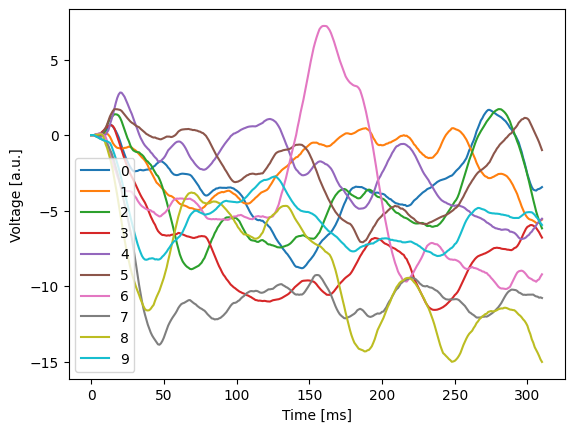

In [51]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trained_snn = model.snn.to(DEVICE)
frames = frames.to(DEVICE)

# Hier gehen wir davon aus, dass 'frames' mehrere Eingabebeispiele enthalten kann.
trained_readout_voltages = trained_snn(frames[:, :1])  # Nur das erste Beispiel (falls frames mehr als eines enthält)

# Um die Spannung zu plotten, holen wir die Daten von der GPU und konvertieren sie zu NumPy
voltages = trained_readout_voltages.squeeze(1).cpu().detach().numpy()

# Falls mehrere Klassen oder Kanäle vorhanden sind, iteriere durch sie
for i in range(voltages.shape[1]):  # Annahme: Zweite Dimension entspricht den Klassen/Kanälen
    plt.plot(voltages[:, i], label=f"{i}")

# Achsenbeschriftung
plt.ylabel("Voltage [a.u.]")
plt.xlabel("Time [ms]")

# Legende anzeigen
plt.legend()

# Plot anzeigen
plt.show()
